<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/data_extraction+curation/Data_Curration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Antioxidants Data Curation (Data from AODB)

In [ ]:
!pip install rdkit # Order of installment was important now it should work
!pip install networkx[default]



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 16.9 MB/s eta 0:00:00


In [ ]:
#RUN THIS CELL IF func.py CHANGES

#get functions from functions file (still have to move most of the functions there!)
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/df_dpph.csv

!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/connected_df.csv

#from func import is_substruct_in, convert_smiles_series_to_fp_to_np_array, convert_smiles_series_to_fp_to_np_array_exception_handling
#why import functions one by one?
#could be executed alternatively by:
%run func.py


--2025-05-07 20:01:34--  https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py [following]
--2025-05-07 20:01:34--  https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6467 (6.3K) [text/plain]
Saving to: ‘func.py’

func.py             100%[===================>]   6.32K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-05-07 20:01:34 (52.7 MB/s) - ‘func.py’ sav

In [ ]:
#Import packages

import pandas as pd
import re
import numpy as np
import os
from google.colab import drive
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
import matplotlib.pyplot as plt
import math
from sklearn.manifold import TSNE
RDLogger.DisableLog("rdApp.info")

In [ ]:
#Get data export from AODB by adding it (locally) or in drive (colab needs to be connected to drive)
drive.mount('/content/drive', force_remount=True)

file_path = "/content/drive/MyDrive/AODB_antio_compounds.csv" #https://drive.google.com/file/d/1oc3pU4BPqn1T-Rta9qZtYNfypGgWt3XH/view?usp=sharing to get acces to csv
df_AODB_all = pd.read_csv(file_path)

#if first converted to xlsx
#file_path = "/content/drive/MyDrive/Colab Notebooks/AODB_antio_compounds.xlsx"
#df_AODB_all = pd.read_excel(file_path)

# Print the first 5 rows of the dataset
df_AODB_all.head()

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AODB_antio_compounds.csv'

## Filtering

In [ ]:
print(len(df_AODB_all))
#print(dataset_initial.columns)
#print(df_AODB_all.columns)

#Filter Data rows for data curation (determined by inspection of data)
df_dpph = df_AODB_all[df_AODB_all["Assay Description"].str.contains("DPPH", case=False, na=False) &
          df_AODB_all["Experimental Data"].str.contains("IC50|EC50", case=False, na=False)
      & ~df_AODB_all["Experimental Data"].str.contains("relative|1/IC50|1/EC50|ratio", case=False, na=False)
      & ~df_AODB_all["Activity Comment"].str.contains("Dose dependent data|Not determined", case=False, na=False)
      & ~df_AODB_all["Target Organism"].str.contains("Rattus norvegicus", case=False, na=False)
      & ~df_AODB_all["Assay Description"].str.contains("liposome|relative|ratio|rat brain", case=False, na=False)
      & (df_AODB_all["Molecular Weight"] <= 1000)  # filter only small MW compounds
]
print(len(df_dpph))
#Reset index
df_dpph.reset_index(drop=True, inplace=True)

98313
5187


## Canonicalize and Standardize SMILES

In [ ]:
#standardize and canonicalize smiles and add new column canonical_Smiles
df_dpph["canonical_Smiles"] = df_dpph["SMILES"].apply(rdMolStandardize.StandardizeSmiles)

<ipython-input-26-2af55461c78b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dpph["canonical_Smiles"] = df_dpph["SMILES"].apply(rdMolStandardize.StandardizeSmiles)


## Convert Activity values (problems if run multiple times)

In [ ]:
# Apply parsing and expand into new columns
parsed_data = df_dpph['Experimental Data'].apply(parse_experimental_data).apply(pd.Series)

# Combine with original DataFrame
df_dpph = pd.concat([df_dpph, parsed_data], axis=1)

# Display results
df_dpph.head()

,AOX ID,SMILES,InChI,Molecular Formula,Molecular Weight,AlogP,HBD,HBA,Polar Surface Area,Rotatable Bonds,...,PPB,PPB Prediction,PPB Applicability,PPB Applicability MD,PPB Applicability MDpvalue,canonical_Smiles,activity_type,operator,activity_value,units
0,AOXMO00050,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,InChI=1S/C18H15NO3/c20-9-19-6-5-12-8-15-18(22-...,C18H15NO3,293.3,2.69,0,4,38.8,1,...,3.835750,1.0,All properties and OPS components are within e...,16.9487,0.000002,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,IC50,=,121400.0,nM
1,AOXMO00051,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,C6H8O6,176.1,-1.41,4,6,107.2,2,...,-13.991000,0.0,All properties and OPS components are within e...,14.3277,0.048874,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,IC50,=,52100.0,nM
2,AOXMO00487,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H17N3O/c1-14-17(19-13-15-9-5-3-6-1...,C18H17N3O,291.4,3.24,0,4,39.3,3,...,-3.209610,0.0,All properties and OPS components are within e...,11.4141,0.980298,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31260.0,nM
3,AOXMO00488,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H16ClN3O/c1-13-17(20-12-14-8-10-15...,C18H16ClN3O,325.8,3.89,0,4,39.3,3,...,0.040773,1.0,All properties and OPS components are within e...,12.4505,0.751763,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31680.0,nM
4,AOXMO00489,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C20H22N4O/c1-15-19(21-14-16-10-12-17(...,C20H22N4O,334.4,3.30,0,5,42.5,4,...,-2.777630,0.0,All properties and OPS components are within e...,14.6459,0.021033,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,2430.0,nM


In [ ]:
# Apply conversion and force float dtype
df_dpph['value_nM'] = df_dpph.apply(convert_units, axis=1).astype(float)

In [ ]:
#check if ugmL-1 were properly converted
print(df_dpph[df_dpph['units']=='ugmL-1'])

          AOX ID                                             SMILES  \
18    AOXMO00508                 Cc1n[nH]c(=O)n1/N=C/c1ccc(O)c(O)c1   
19    AOXMO00509         O=c1[nH]nc(Cc2ccccc2)n1/N=C/c1ccc(O)c(O)c1   
20    AOXMO00510     O=c1[nH]nc(Cc2ccc(Cl)cc2)n1/N=C/c1ccc(O)c(O)c1   
21    AOXMO00511     COc1ccc(Cc2n[nH]c(=O)n2/N=C/c2ccc(O)c(O)c2)cc1   
22    AOXMO00512         O=c1[nH]nc(-c2ccccc2)n1/N=C/c1ccc(O)c(O)c1   
...          ...                                                ...   
4849  AOXMO44737  Cc1ccc2c3c([nH]c2c1)C1=C(C#N)C(=O)NC1(C1C(=O)N...   
4850  AOXMO44738                    O=C1O[C@H]([C@@H](O)CO)C(O)=C1O   
4956  AOXMO46263  CCOC(=O)c1cc2ccc(OCc3cn(Cc4ccc([N+](=O)[O-])cc...   
4957  AOXMO46264                   Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1   
5009  AOXMO46434             Cc1ccc(C(=O)CC(=O)c2cc3ccccc3s2)c(O)c1   

                                                  InChI Molecular Formula  \
18    InChI=1S/C10H10N4O3/c1-6-12-13-10(17)14(6)11-5...        C10H10N

In [ ]:
# Apply conversion to each row of the compounds DataFrame
df_dpph["pIC50"] = df_dpph.apply(lambda x: convert_ic50_to_pic50(x.value_nM), axis=1)
df_dpph.head()

,AOX ID,SMILES,InChI,Molecular Formula,Molecular Weight,AlogP,HBD,HBA,Polar Surface Area,Rotatable Bonds,...,PPB Applicability,PPB Applicability MD,PPB Applicability MDpvalue,canonical_Smiles,activity_type,operator,activity_value,units,value_nM,pIC50
0,AOXMO00050,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,InChI=1S/C18H15NO3/c20-9-19-6-5-12-8-15-18(22-...,C18H15NO3,293.3,2.69,0,4,38.8,1,...,All properties and OPS components are within e...,16.9487,0.000002,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,IC50,=,121400.0,nM,121400.0,3.915781
1,AOXMO00051,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,C6H8O6,176.1,-1.41,4,6,107.2,2,...,All properties and OPS components are within e...,14.3277,0.048874,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,IC50,=,52100.0,nM,52100.0,4.283162
2,AOXMO00487,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H17N3O/c1-14-17(19-13-15-9-5-3-6-1...,C18H17N3O,291.4,3.24,0,4,39.3,3,...,All properties and OPS components are within e...,11.4141,0.980298,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31260.0,nM,31260.0,4.505011
3,AOXMO00488,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H16ClN3O/c1-13-17(20-12-14-8-10-15...,C18H16ClN3O,325.8,3.89,0,4,39.3,3,...,All properties and OPS components are within e...,12.4505,0.751763,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31680.0,nM,31680.0,4.499215
4,AOXMO00489,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C20H22N4O/c1-15-19(21-14-16-10-12-17(...,C20H22N4O,334.4,3.30,0,5,42.5,4,...,All properties and OPS components are within e...,14.6459,0.021033,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,2430.0,nM,2430.0,5.614394


## Visual inspection of data

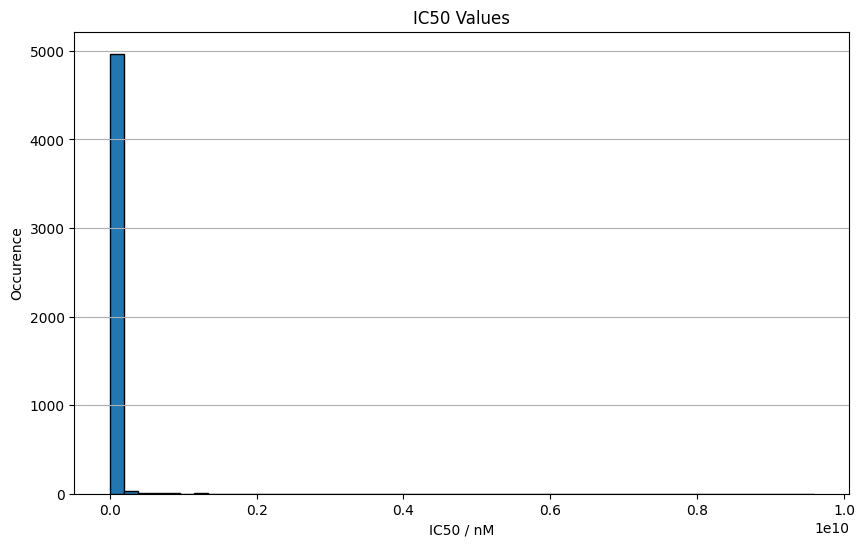

In [ ]:
# Histogram of IC50 values in nM
plt.figure(figsize=(10, 6))
plt.hist(df_dpph['value_nM'], bins=50, edgecolor='black')
plt.title('IC50 Values')
plt.xlabel('IC50 / nM')
plt.ylabel('Occurence')
plt.grid(axis='y')

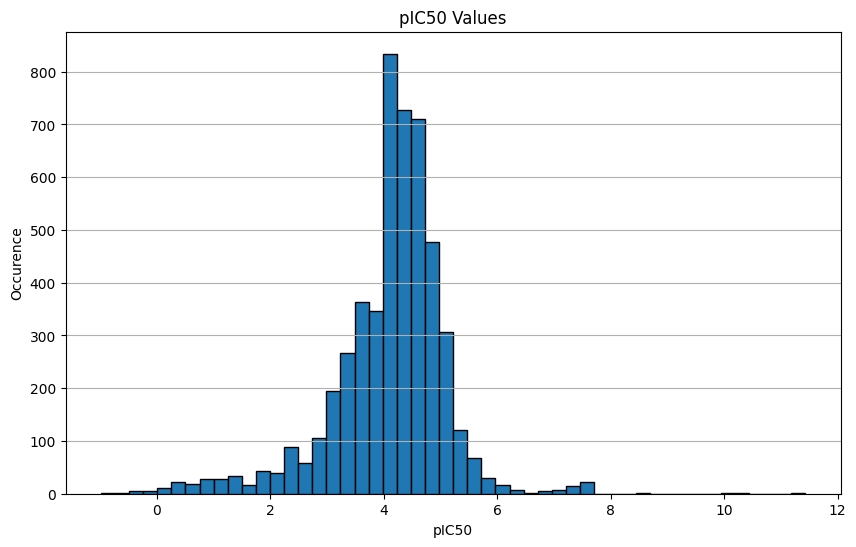

In [ ]:
# Histogram of pIC50 values
plt.figure(figsize=(10, 6))
plt.hist(df_dpph['pIC50'], bins=50, edgecolor='black')
plt.title('pIC50 Values')
plt.xlabel('pIC50')
plt.ylabel('Occurence')
plt.grid(axis='y')

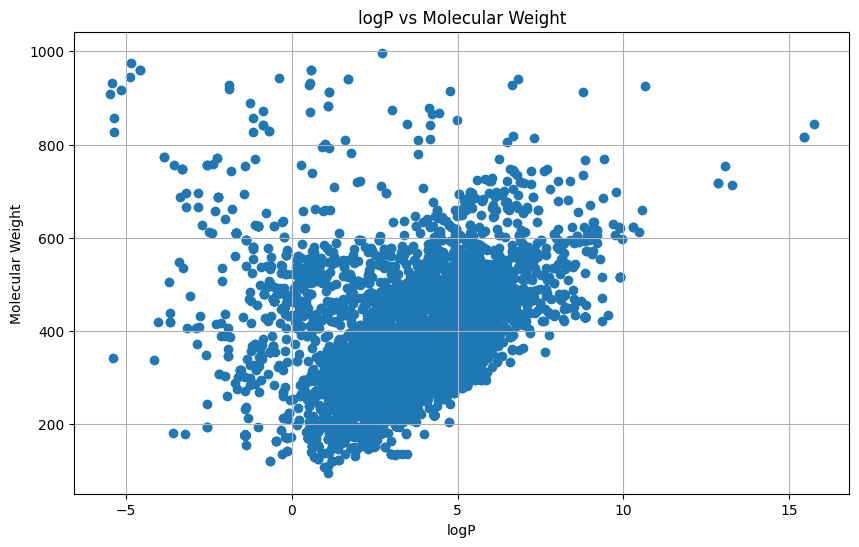

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_dpph['AlogP'], df_dpph['Molecular Weight'])
plt.title('logP vs Molecular Weight')
plt.xlabel('logP')
plt.ylabel('Molecular Weight')
plt.grid(True)

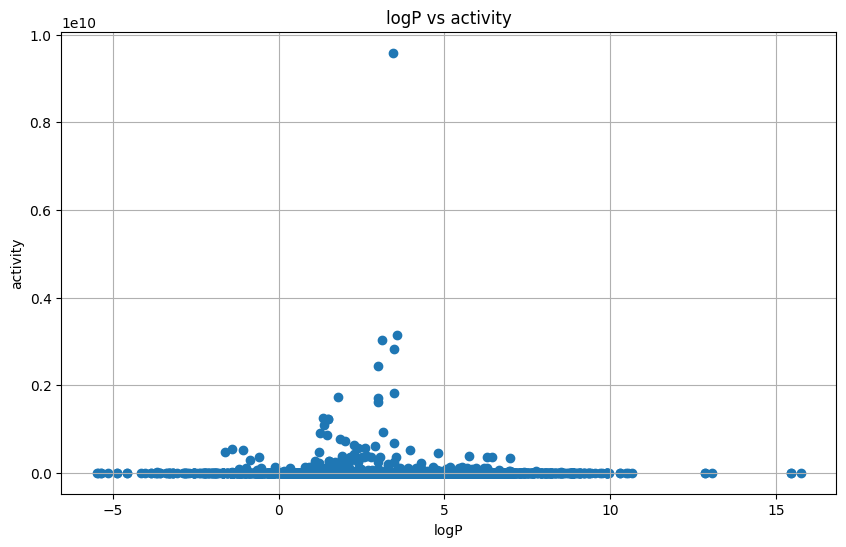

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_dpph['AlogP'], df_dpph['value_nM']) #why do you take value_nM and not pIC50?
plt.title('logP vs activity')
plt.xlabel('logP')
plt.ylabel('activity')
plt.grid(True)

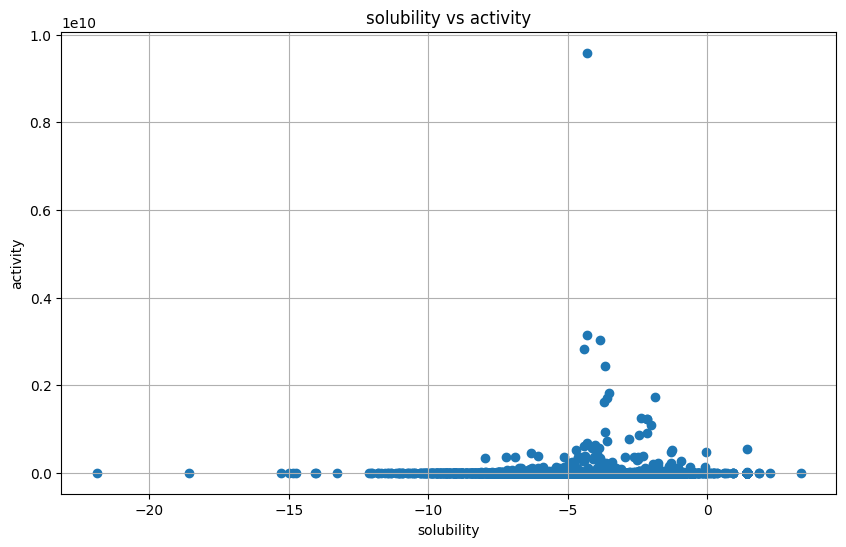

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_dpph['Solubility'], df_dpph['value_nM']) #same here: why do you not take pIC50?
plt.title('solubility vs activity')
plt.xlabel('solubility')
plt.ylabel('activity')
plt.grid(True)



```
# This is formatted as code
```

## Other Data Inspection

In [ ]:
#inspect high activity value compounds
print(df_dpph[df_dpph['value_nM']>1*10**9])

          AOX ID                                    SMILES  \
974   AOXMO09606                       O=C(O)/C=C/c1ccccc1   
995   AOXMO09627               O=c1cc(-c2ccccc2)oc2ccccc12   
1006  AOXMO09638  O=C(/C=C/c1ccc([N+](=O)[O-])cc1)c1ccccc1   
1007  AOXMO09639                O=C(/C=C/c1ccccc1)c1ccccc1   
1887  AOXMO17929            O=C(O)CCCc1nc2ccccc2c(=O)[nH]1   
1888  AOXMO17930                 O=C(O)CCc1nc(O)c2ccccc2n1   
2184  AOXMO19277                       O=c1ccc2ccc(O)cc2o1   
2185  AOXMO19278                       O=c1ccc2cc(O)ccc2o1   
2475  AOXMO22010                         CC1=CCC2CC1C2(C)C   
2476  AOXMO22011                       C=C1CCC2(C(C)C)CC12   
2477  AOXMO22012                         C=C1CCC2CC1C2(C)C   
2479  AOXMO22014                         C=CC(=C)CCC=C(C)C   
2481  AOXMO22016                          Cc1ccc(C(C)C)cc1   

                                                  InChI Molecular Formula  \
974   InChI=1S/C9H8O2/c10-9(11)7-6-8-4-2-1-3-5-8/h1-..

### DPPH assay different times (10min, 30min)

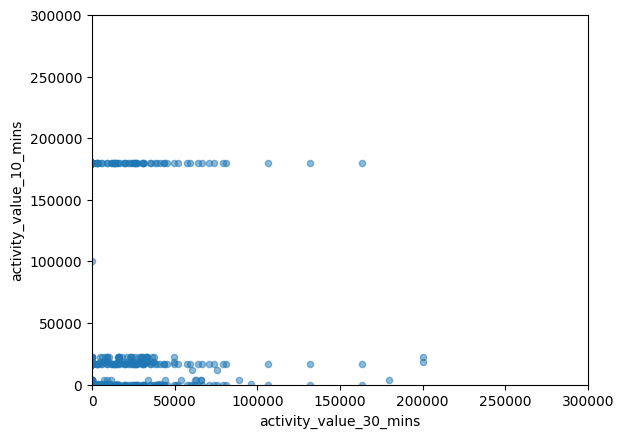

,AOX ID_30_mins,SMILES_30_mins,InChI_30_mins,Molecular Formula_30_mins,Molecular Weight_30_mins,AlogP_30_mins,HBD_30_mins,HBA_30_mins,Polar Surface Area_30_mins,Rotatable Bonds_30_mins,...,PPB Prediction_10_mins,PPB Applicability_10_mins,PPB Applicability MD_10_mins,PPB Applicability MDpvalue_10_mins,activity_type_10_mins,operator_10_mins,activity_value_10_mins,units_10_mins,value_nM_10_mins,pIC50_10_mins
0,AOXMO11629,Brc1ccc(-c2csc(N/N=C/c3cc4ccccc4s3)n2)cc1,InChI=1S/C18H12BrN3S2/c19-14-7-5-12(6-8-14)16-...,C18H12BrN3S2,414.4,6.23,1.0,3.0,37.3,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AOXMO30057,Brc1ccc(Cn2cc(COc3ccccc3)nn2)cc1,InChI=1S/C16H14BrN3O/c17-14-8-6-13(7-9-14)10-2...,C16H14BrN3O,344.2,3.67,0.0,4.0,39.9,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AOXMO11632,C(=N/Nc1nc(C23CC4CC(CC(C4)C2)C3)cs1)\c1cc2cccc...,InChI=1S/C22H23N3S2/c1-2-4-19-17(3-1)8-18(27-1...,C22H23N3S2,393.6,6.27,1.0,3.0,37.3,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AOXMO24681,C(=N/c1ccccc1)\c1ccccc1,InChI=1S/C13H11N/c1-3-7-12(8-4-1)11-14-13-9-5-...,C13H11N,181.2,3.44,0.0,1.0,12.4,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AOXMO18035,C/C(=C/O[C@@H]1O[C@H](COC(=O)c2cc(O)c(O)c(O)c2...,InChI=1S/C17H20O12/c1-6(15(24)25)4-28-17-14(23...,C17H20O12,416.3,-1.23,7.0,12.0,203.4,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#not sure but first 3 rows can probably be removed
#parsed_data = df_dpph['Experimental Data'].apply(parse_experimental_data).apply(pd.Series)
#df_dpph = pd.concat([df_dpph, parsed_data], axis=1)
#df_dpph["value_nM"] = df_dpph.apply(convert_units, axis = 1)

#inspect values for 10 min and 30 min assays
df_dpph_10_mins = df_dpph[df_dpph["Assay Description"].str.contains("10 mins", case=False, na=False)]
df_dpph_30_mins = df_dpph[df_dpph["Assay Description"].str.contains("30 mins", case=False, na=False)]


#merge filtered dataframes
#maybe give a better name for later use?
merged_df = pd.merge(df_dpph_30_mins, df_dpph_10_mins, on=["canonical_Smiles"], how="outer", suffixes=('_30_mins', '_10_mins'))

#in the received dataframe duplicates of substances after canonical smiles are joined
#in the same row, the columns with the descriptors etc. are duplicated and the suffixes
#_30_min and _10_min are added to each column

merged_df = merged_df.dropna(subset=["activity_value_30_mins", "activity_value_10_mins"], how="all")
merged_df[["activity_value_30_mins", "activity_value_10_mins"]].dropna().plot(kind="scatter", x="activity_value_30_mins", y="activity_value_10_mins", alpha=0.5)
plt.xlim([0, 300000])
plt.ylim([0, 300000])
plt.xlabel("activity_value_30_mins")
plt.ylabel("activity_value_10_mins")
plt.show()
df_dpph.columns #why plot columns of old df?
merged_df.head()


### Phenolic or not phenolic?

In [ ]:
#check with phenol SMARTS if compounds are phenolic

phenol = "c1ccccc1[OH]"
df_dpph["is_phenol"] = df_dpph["canonical_Smiles"].apply(is_substruct_in, substruct_smarts = phenol)

print(len(df_dpph[df_dpph["is_phenol"] == True]), len(df_dpph))

fp_array = convert_smiles_series_to_fp_to_np_array(df_dpph["canonical_Smiles"])

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(fp_array)

3053 5187


Streaming output truncated to the last 5000 lines.
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:06:40] DEPRECATION WARNING: please use MorganGenerator
[14:0

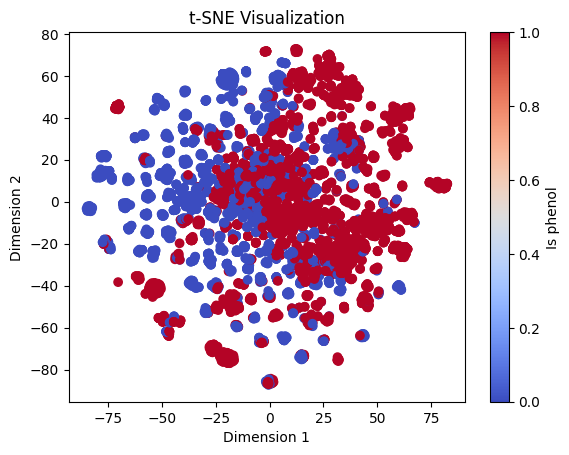

In [ ]:
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=df_dpph["is_phenol"], cmap="coolwarm")
cb = plt.colorbar()
cb.set_label("Is phenol")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.title("t-SNE Visualization")
plt.show()

In [ ]:
#Hello

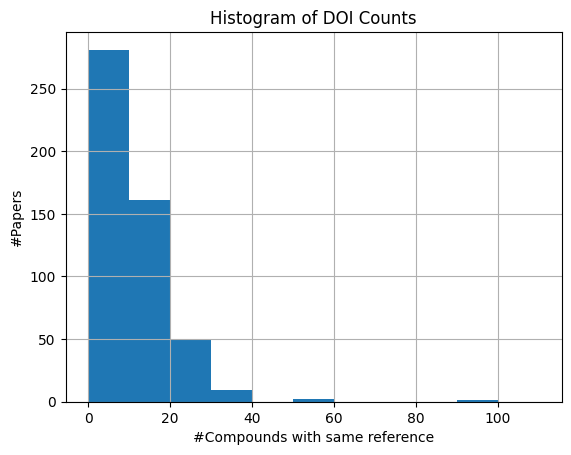

,count
DOI,
10.1016/j.bmcl.2012.12.001,91
10.1016/j.bmc.2014.10.015,50
10.1016/j.bmcl.2014.09.028,50
10.1016/j.ejmech.2010.04.013,39
10.1016/j.ejmech.2011.08.010,37
...,...
10.1016/j.ejmech.2019.04.021,1
10.1007/s00044-010-9461-8,1
10.1021/acsmedchemlett.6b00077,1


In [ ]:
#intention of df_test?
df_test = df_dpph[["canonical_Smiles", "activity_value"]]

#getting information about literature sources
df_doi_counts = df_dpph["DOI"].value_counts()

binsize = 10
bins = np.arange(0, 120, binsize)
plt.hist(df_doi_counts, bins=bins)
plt.xlabel("#Compounds with same reference")
plt.ylabel("#Papers")
plt.title("Histogram of DOI Counts")
plt.grid()
plt.show()
df_doi_counts

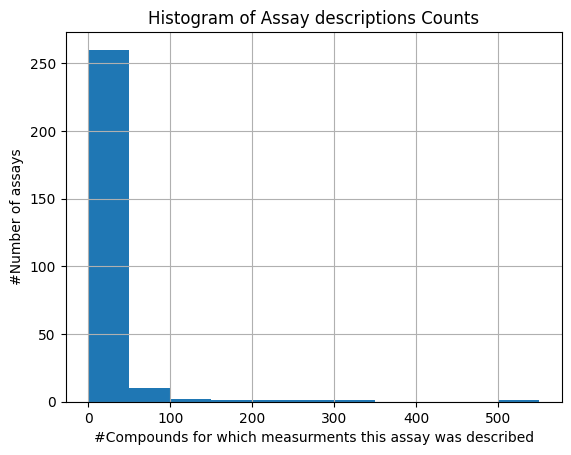

,count
Assay Description,
Antioxidant activity assessed as DPPH radical scavenging activity,514
Antioxidant activity assessed as DPPH radical scavenging activity after 30 mins,311
Antioxidant activity assessed as DPPH free radical scavenging activity after 30 mins,273
Antioxidant activity assessed as DPPH free radical scavenging activity,211
Antioxidant activity assessed as DPPH radical scavenging activity after 30 mins by spectrophotometry,157
...,...
Antioxidant activity assessed as radical scavenging activity incubated for 20 mins by DPPH assay based UV spectrophotometer analysis,1
Antioxidant activity assessed as DPPH free radical scavenging activity within 1 mins,1
Antioxidant activity assessed as DPPH radical scavenging activity measured for each 5 mins for 3 hrs,1


In [ ]:
df_assay_desc_count = df_dpph["Assay Description"].value_counts()

#getting information about assay descriptions

binsize = 50
bins = np.arange(0, 600, binsize)
plt.hist(df_assay_desc_count, bins=bins)
plt.xlabel("#Compounds for which measurments this assay was described")
plt.ylabel("#Number of assays")
plt.title("Histogram of Assay descriptions Counts")
plt.grid()
plt.show()
df_assay_desc_count

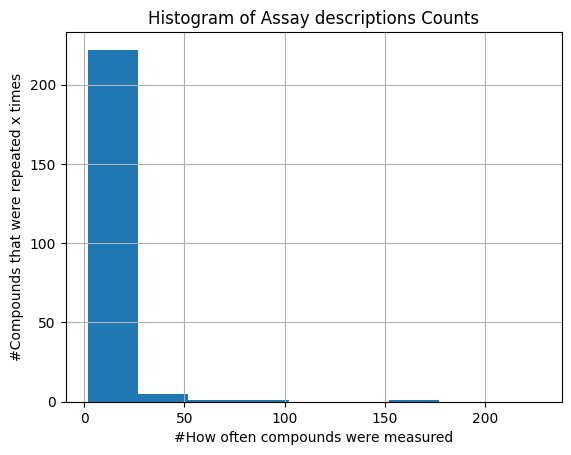

,count
canonical_Smiles,
O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,168
Cc1c(C)c2c(c(C)c1O)CCC(C)(C(=O)O)O2,79
Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,57
Cc1c(C)c2c(c(C)c1O)CC[C@@](C)(CCC[C@H](C)CCC[C@H](C)CCCC(C)C)O2,40
O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,39
...,...
COc1cc(OC)c(OC)cc1/C=C/C(=O)c1ccc(F)cc1,1
COc1cc(OC)c(OC)cc1/C=C/C(=O)c1ccc(O)cc1O,1
Cc1cc(O)c(C(C)C)cc1/N=C/c1ccc2c(c1)OCO2,1


In [ ]:
df_canonical_smiles_count = df_dpph["canonical_Smiles"].value_counts()

binsize = 25
bins = np.arange(2, 250, binsize)       #most of the compounds (>4000) occure only once or twice --> excluded for better readability of histogram
plt.hist(df_canonical_smiles_count, bins=bins)
plt.xlabel("#How often compounds were measured")
plt.ylabel("#Compounds that were repeated x times")
plt.title("Histogram of Assay descriptions Counts")
plt.grid()
plt.show()
df_canonical_smiles_count

## Save dataframe as csv to Github

In [ ]:
#already on github now
df_dpph = pd.read_csv("df_dpph.csv")
df_dpph.columns

Index(['Unnamed: 0', 'AOX ID', 'SMILES', 'InChI', 'Molecular Formula',
       'Molecular Weight', 'AlogP', 'HBD', 'HBA', 'Polar Surface Area',
       'Rotatable Bonds', 'QED Weighted', 'Chiral Center', 'Aromatic Rings',
       'Heavy Atoms', 'PubChem CID', 'PubChem AID', 'ChEMBL ID', 'NCBI:txid',
       'NCBI Gene ID', 'Protein Target ID', 'PMID', 'DOI', 'Assay Description',
       'Source', 'Assay Type', 'Activity Comment', 'Target Organism',
       'Protein Target Name', 'Standard Deviation', 'Assay Description ',
       'Average Activation at 10.6 uM, %', 'Kd, uM', 'Inhibition at 50 uM , %',
       'Inhibition at 5 uM , % ', 'Activation at 10.6 uM, %',
       'Relative transcription levels at 1uM, %', 'Percent Response, %',
       'Phenotype', 'Potency', 'Efficacy', 'Phenotype-Replicate_1',
       'Potency-Replicate_1', 'Efficacy-Replicate_1', 'Experimental Data',
       'Target ChEMBL ID', 'Target Pref Name', 'Cell Line Target',
       'Solubility', 'Solubility Level', 'AlogP98', '

## Landrum et al. inspired data curation (10.1021/acs.jcim.4c00049)



In [ ]:
df_model_1 = df_dpph["canonical_Smiles"].value_counts().reset_index()
repeated_smiles = df_model_1[df_model_1["count"] > 1]["canonical_Smiles"]
df_model_1 = df_dpph[df_dpph["canonical_Smiles"].isin(repeated_smiles)]

df_model_1_grouped = df_model_1.groupby(["canonical_Smiles"])["value_nM"].mean()
df_model_1_grouped.head()


,value_nM
canonical_Smiles,
C/C=C/c1ccc2oc(-c3ccc(O)cc3O)cc2c1,22100.000000
C/C=C/c1ccc2oc(-c3ccc(O)cc3OC)cc2c1,36300.000000
C/C=C/c1ccc2oc(-c3ccc(OC)cc3O)cc2c1,24200.000000
CC(=O)N[C@@H](CS)C(=O)O,46966.666667
CC(C)(C)c1cc(O)ccc1O,47626.000000


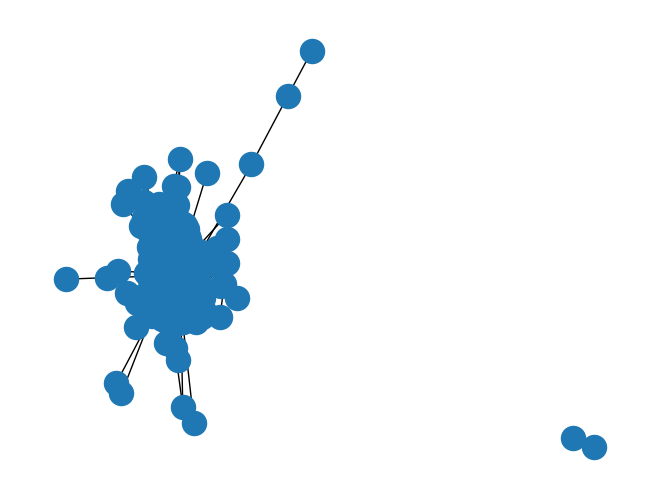

Final curated DataFrame has 3267 unique canonical_Smiles and 217 unique assay descriptions.


,Unnamed: 0,AOX ID,SMILES,InChI,Molecular Formula,Molecular Weight,AlogP,HBD,HBA,Polar Surface Area,...,PPB Applicability MD,PPB Applicability MDpvalue,canonical_Smiles,activity_type,operator,activity_value,units,value_nM,pIC50,is_phenol
0,0,AOXMO00050,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,InChI=1S/C18H15NO3/c20-9-19-6-5-12-8-15-18(22-...,C18H15NO3,293.3,2.69,0,4,38.8,...,16.9487,0.000002,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,IC50,=,121400.0,nM,121400.0,3.915781,0
1,1,AOXMO00051,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,C6H8O6,176.1,-1.41,4,6,107.2,...,14.3277,0.048874,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,IC50,=,52100.0,nM,52100.0,4.283162,0
2,2,AOXMO00487,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H17N3O/c1-14-17(19-13-15-9-5-3-6-1...,C18H17N3O,291.4,3.24,0,4,39.3,...,11.4141,0.980298,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31260.0,nM,31260.0,4.505011,0
3,3,AOXMO00488,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H16ClN3O/c1-13-17(20-12-14-8-10-15...,C18H16ClN3O,325.8,3.89,0,4,39.3,...,12.4505,0.751763,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31680.0,nM,31680.0,4.499215,0
4,4,AOXMO00489,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C20H22N4O/c1-15-19(21-14-16-10-12-17(...,C20H22N4O,334.4,3.30,0,5,42.5,...,14.6459,0.021033,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,2430.0,nM,2430.0,5.614394,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,5182,AOXMO47445,O=C(OCCc1ccc(O)cc1)c1cc(O)c(O)c(O)c1,InChI=1S/C15H14O6/c16-11-3-1-9(2-4-11)5-6-21-1...,C15H14O6,290.3,1.91,4,6,107.2,...,11.8268,0.933475,O=C(OCCc1ccc(O)cc1)c1cc(O)c(O)c(O)c1,IC50,=,7520.0,nM,7520.0,5.123782,1
3866,5183,AOXMO47446,O=C(OCCc1ccccc1O)c1cc(O)c(O)c(O)c1,InChI=1S/C15H14O6/c16-11-4-2-1-3-9(11)5-6-21-1...,C15H14O6,290.3,1.91,4,6,107.2,...,12.0444,0.887349,O=C(OCCc1ccccc1O)c1cc(O)c(O)c(O)c1,IC50,=,8310.0,nM,8310.0,5.080399,1
3867,5184,AOXMO47447,O=C(OCCc1cccc(O)c1)c1cc(O)c(O)c(O)c1,InChI=1S/C15H14O6/c16-11-3-1-2-9(6-11)4-5-21-1...,C15H14O6,290.3,1.91,4,6,107.2,...,13.0616,0.459216,O=C(OCCc1cccc(O)c1)c1cc(O)c(O)c(O)c1,IC50,=,7780.0,nM,7780.0,5.109020,1
3868,5185,AOXMO47448,Cc1c(C)c2c(c(C)c1O)CC[C@@](C)(CCC[C@H](C)CCC[C...,InChI=1S/C29H50O2/c1-20(2)12-9-13-21(3)14-10-1...,C29H50O2,430.7,8.84,1,2,29.5,...,17.0697,0.000001,Cc1c(C)c2c(c(C)c1O)CC[C@@](C)(CCC[C@H](C)CCC[C...,IC50,=,9890.0,nM,9890.0,5.004804,1


In [ ]:
import networkx as nx

def extract_connected_assays(df):
    """
    Extracts rows from the input dataframe (df_dpph) that have operator '='
    and belong to canonical_Smiles groups for which the compound was measured
    in at least two different assays (Assay Description) with pIC50 values that
    are in close agreement (absolute difference less than 0.3).

    Parameters:
      df (pd.DataFrame): Input dataframe with the following columns:
                         'operator', 'canonical_Smiles', 'pIC50',
                         'Assay Description', and 'DOI'.

    Returns:
      pd.DataFrame: A filtered dataframe containing only those rows from
                    assays that are connected via compatible pIC50 measurements.
    """
    # Work only on the rows where the operator is "=".
    df_eq = df[df['operator'] == '='].copy()
    connected_assays = set()
    # Use a set to gather indices of rows meeting the connection criterion.
    excluded_assays = set()
    rows_to_drop = set()


    assay_1 = []
    assay_2 = []
    Graph = nx.Graph()

    # Group the data by canonical_Smiles.
    for smile, group in df_eq.groupby('canonical_Smiles'):    #return value of groupby() is a single value (here a string) and a dataframe

        # Only consider groups measured in at least two different assay descriptions.
        assay_descs = group['Assay Description'].unique()
        if len(assay_descs) < 2:
            continue

        # Flag to check if at least one pair of rows (from different assays) meets the criterion.
        found_connection = False
        group_indices = group.index.tolist()
        if len(group_indices) < 2:
          break
        # Compare every unique pair from the group.
        for i in range(len(group_indices)):

            for j in range(i + 1, len(group_indices)):
                row_i = group.loc[group_indices[i]]
                row_j = group.loc[group_indices[j]]

                # Only consider pairs coming from different assay descriptions.
                if row_i['Assay Description'] != row_j['Assay Description']:
                  if row_i['DOI'] == row_j['DOI']: #if assays are from the same doi skip the loop
                    continue
                  if row_i["pIC50"]==row_j["pIC50"]:
                    rows_to_drop.update([row_i.name])
                    rows_to_drop.update([row_j.name])
                  if row_i["canonical_Smiles"] == row_j["canonical_Smiles"]:
                    diff = abs(row_i['pIC50'] - row_j['pIC50'])
                    #if diff > 3:  #including breaking conditon where assays differ by power of 3, yeah not really a good Idea in hindsight is removed
                      #break
                    if diff < 0.3:
                        #connected_indices.add(group_indices[i])
                        #connected_indices.add(group_indices[j])
                        edge_1 = row_i["Assay Description"]
                        edge_2 = row_j["Assay Description"]
                        Graph.add_edge(edge_1, edge_2)








    for edge in nx.connected_components(Graph):
      if len(edge) > 1: #only get assays which are connected to more than 1 other assay
          connected_assays.update(edge)
    largest_cc = max(nx.connected_components(Graph), key=len) #only return the largest graph not a small subgraph
    connected_assays.update(largest_cc)

    df_eq.drop(index=rows_to_drop, inplace=True)


    #connected_assays = [node for node, degree in Graph.degree() if degree > 2]
    # Return the subset of rows that are connected.
    return df_eq.loc[df_eq["Assay Description"].isin(connected_assays)].reset_index(drop=True), assay_1, assay_2, Graph


connected_df, assay_1, assay_2, Graph = extract_connected_assays(df_dpph)

# Now, connected_df contains all rows from assays that are connected
# via a canonical smile measured in at least two different assays with |ΔpIC50| < 0.3.
nx.draw_spring(Graph, with_labels=False)
plt.show()


# Now, report the number of unique canonical smiles and assay descriptions in the final dataframe.
num_smiles = connected_df['canonical_Smiles'].nunique()
num_assays = connected_df['Assay Description'].nunique()
print(f"Final curated DataFrame has {num_smiles} unique canonical_Smiles and {num_assays} unique assay descriptions.")
connected_df

In [ ]:
connected_df=pd.read_csv("connected_df.csv")

In [ ]:
connected_df['Assay Description'].value_counts()
connected_df_unique_smiles = connected_df[["SMILES", "is_phenol"]].drop_duplicates().reset_index(drop=True)
phenolic_compounds = len(connected_df_unique_smiles[connected_df_unique_smiles['is_phenol'] == 1])

print(f"Phenolic compounds: {phenolic_compounds} left of total {len(connected_df_unique_smiles)}")

#printed names of assays to manually check the left-over descriptions.
#apparantly there are assays with different duration, ranging from 30-270 min.
#is it reasonable, that these assays are comparable? maybe due to saturation or so?

Phenolic compounds: 1954 left of total 3267


3267


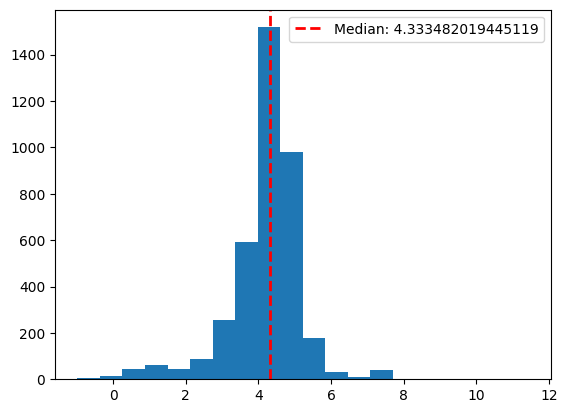

In [ ]:

connected_df_grouped = connected_df[["canonical_Smiles", "pIC50"]].groupby("canonical_Smiles").agg(['mean', 'median', 'var']).reset_index() #grouping the assays values by the median and also return mean and variance, as we can argue it is more meaningful than a mean which is sensitive to outliers
print(len(connected_df_grouped))
median = connected_df["pIC50"].median()

plt.hist(connected_df["pIC50"], bins = 20)
plt.axvline(x = median, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median}")
plt.legend()

In [ ]:
connected_df.head()

,canonical_Smiles,Unnamed: 0,Molecular Weight,AlogP,HBD,HBA,Polar Surface Area,Rotatable Bonds,QED Weighted,Chiral Center,...,Hepatotoxic Applicability MDpvalue,Absorption Level,PPB,PPB Prediction,PPB Applicability MD,PPB Applicability MDpvalue,activity_value,value_nM,pIC50,is_phenol
0,Brc1ccc(-c2csc(N/N=C/c3cc4ccccc4s3)n2)cc1,1205.0,414.4,6.23,1.0,3.0,37.3,4.0,0.32,0.0,...,2.740000e-05,1.0,4.47982,1.0,15.6698,0.000659,36900.00,36900.0,4.432974,0.0
1,Brc1ccc(Cn2cc(COc3ccccc3)nn2)cc1,3467.0,344.2,3.67,0.0,4.0,39.9,5.0,0.71,0.0,...,7.420000e-11,0.0,1.77903,1.0,14.0735,0.088361,18.30,53167.0,4.274358,0.0
2,Brc1ccc2c(c1)Cc1c-2[nH]c2ccccc12,811.0,284.2,4.50,1.0,1.0,15.8,0.0,0.49,0.0,...,2.579230e-01,0.0,2.67988,1.0,13.1163,0.432011,64.12,225616.0,3.646630,0.0
3,C(=N/Nc1nc(-c2ccccc2)cs1)\c1cccs1,114.0,285.4,4.32,1.0,3.0,37.3,4.0,0.57,0.0,...,9.939310e-03,0.0,4.71819,1.0,14.3491,0.046340,26.01,91135.0,4.040315,0.0
4,C(=N/Nc1nc(C23CC4CC(CC(C4)C2)C3)cs1)\c1cc2cccc...,1208.0,393.6,6.27,1.0,3.0,37.3,4.0,0.42,0.0,...,4.200000e-08,1.0,-0.19539,1.0,14.9052,0.009739,15500.00,15500.0,4.809668,0.0


In [ ]:
#saving connected df and connected_df_grouped as csv
connected_df.to_csv("/content/connected_df.csv")


In [ ]:
connected_df_grouped.to_csv("/content/connected_df_grouped.csv")

[np.float64(4.552841968657781), np.float64(4.443697499232713), np.float64(4.443697499232713), np.float64(4.2403321553103694), np.float64(3.6307841425898575), np.float64(3.6307841425898575), np.float64(3.6307841425898575), np.float64(4.442372511573174), np.float64(4.442372511573174), np.float64(4.278519145229951), np.float64(4.682981898951889), np.float64(4.682981898951889), np.float64(4.682981898951889), np.float64(4.682981898951889), np.float64(4.401395502994773), np.float64(4.401395502994773), np.float64(4.401395502994773), np.float64(5.376750709602099), np.float64(5.376750709602099), np.float64(5.207608310501746), np.float64(4.6219656775426685), np.float64(4.646468440922238), np.float64(4.6217838502501225), np.float64(5.920818753952375), np.float64(4.7447274948966935), np.float64(3.505448875755968), np.float64(3.505448875755968), np.float64(3.505448875755968), np.float64(4.705533773838407), np.float64(4.705533773838407), np.float64(4.568636235841013), np.float64(4.516270100999976), 

Text(0, 0.5, 'assay_2 [pIC50]')

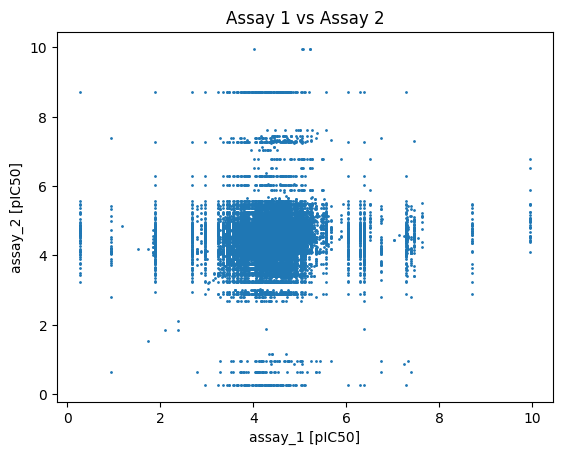

In [ ]:

assay_1 = []
assay_2 = []

for smiles, group in connected_df.groupby("canonical_Smiles"):
  group_indices = group.index.tolist()

  n = len(group_indices)


  for i in range(len(group_indices)):
        for j in range(i + 1, len(group_indices)):  # avoid self-pairs and duplicates
          row_i = connected_df.loc[group_indices[i]]
          row_j = connected_df.loc[group_indices[j]]
          if row_j['Assay Description'] != row_i['Assay Description']:
            #if np.abs(row_i["pIC50"] - row_j["pIC50"]) :
            assay_1.append(row_i['pIC50'])
            assay_2.append(row_j['pIC50'])


print(assay_1)
plt.scatter(assay_1, assay_2, s=1)
plt.title("Assay 1 vs Assay 2")
plt.xlabel("assay_1 [pIC50]")
plt.ylabel("assay_2 [pIC50]")

In [ ]:
outliers = connected_df[connected_df["pIC50"] < 2]
print(f"Number of outliers: {len(outliers['pIC50'])}")
variance = connected_df_grouped[("pIC50", "var")].median()
print(f"Median variance of the pIC50 values: {variance}")

print(f"number of compounds with multiple values (i.e valid variance) which passed the connection test: {len(connected_df_grouped[('pIC50', 'var')].dropna())}")

Number of outliers: 162
Median variance of the pIC50 values: 0.058168379887412816
number of compounds with multiple values (i.e valid variance) which passed the connection test: 136


number of smiles which have a variance (i.e values which exist more than once): 136


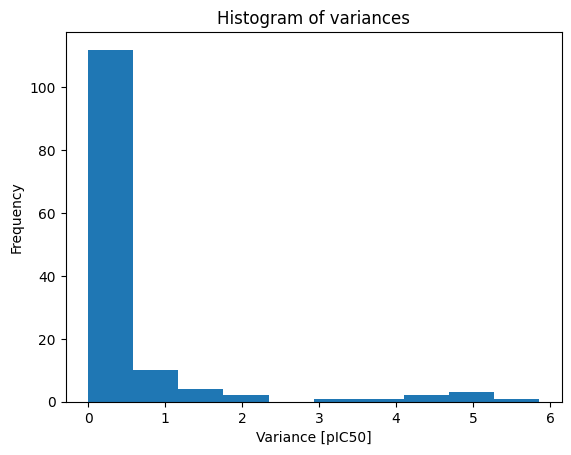

,index,pIC50
,,var
0,155,0.000001
1,225,0.036764
2,235,0.013424
3,293,0.251987
4,294,0.000003
...,...,...
131,3196,0.105737
132,3199,0.001855
133,3201,0.455289


In [ ]:
connected_df_grouped_with_multiple_values = connected_df_grouped[("pIC50", "var")].dropna().reset_index()

valid_variances = connected_df_grouped_with_multiple_values[("pIC50","var")] #getting the variances which are not none and why are not of values with only
print(f"number of smiles which have a variance (i.e values which exist more than once): {len(valid_variances)}")
plt.hist(valid_variances)
plt.title("Histogram of variances")
plt.xlabel("Variance [pIC50]")
plt.ylabel("Frequency")
plt.show()

connected_df_grouped_with_multiple_values#.columns

## 30 min assay duration data curation

2102


(array([2.300e+01, 1.290e+02, 2.470e+02, 1.276e+03, 3.056e+03, 2.410e+02,
        5.300e+01, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([-0.98181861,  0.25966062,  1.50113984,  2.74261907,  3.98409829,
         5.22557751,  6.46705674,  7.70853596,  8.95001519, 10.19149441,
        11.43297363]),
 <BarContainer object of 10 artists>)

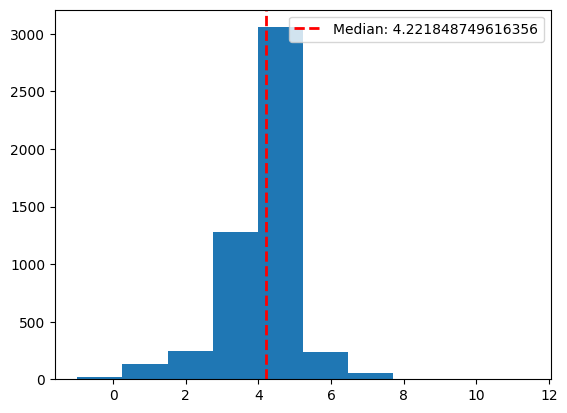

In [ ]:
df_ddph_30min = df_dpph[df_dpph["Assay Description"].str.contains("30 mins", case=False, na=False)]
df_dpph_30min = df_ddph_30min.groupby("canonical_Smiles")["pIC50"].median().reset_index()
median = df_ddph_30min["pIC50"].median()
plt.axvline(x = median, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median}")
plt.legend()

df_dpph_30min.head()
print(len(df_dpph_30min))
plt.hist(df_dpph["pIC50"])

## Minimal data curation

§

4342


(array([  52.,  134.,  396., 1750., 1752.,  102.,   28.,    0.,    0.,
           2.]),
 array([-0.48290765,  0.70868048,  1.90026861,  3.09185674,  4.28344487,
         5.47503299,  6.66662112,  7.85820925,  9.04979738, 10.24138551,
        11.43297363]),
 <BarContainer object of 10 artists>)

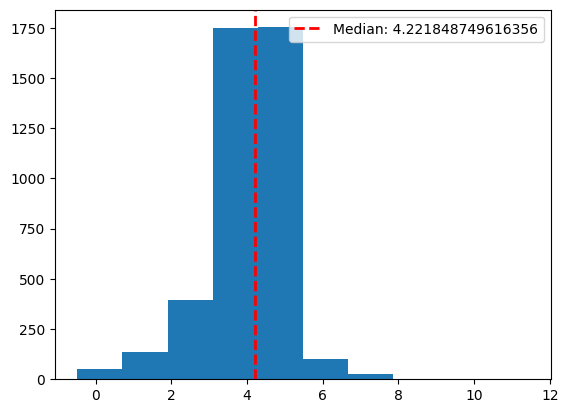

In [ ]:
df_dpph_minimal = df_dpph.groupby("canonical_Smiles")["pIC50"].mean().reset_index()
plt.axvline(x = median, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median}")
plt.legend()
print(len(df_dpph_minimal))
plt.hist(df_dpph_minimal["pIC50"])